In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import Data (Bert Vectors)

In [2]:
#full sentence bert vector
file = '../input/bt5153-train-test-bert-full-sentence/train_data_bert_fullsent.csv'
testfile = '../input/bt5153-train-test-bert-full-sentence/test_data_bert_fullsent.csv'

df = pd.read_csv(file, dtype={'label':str})
df_test = pd.read_csv(testfile, dtype={'label':str})

In [3]:
#merge two datafiles
df_all = pd.concat([df, df_test])
use_cols = ['review_id', 'review_content', 'delivery', 'product', 'service', 'label', 'bert_avg']
df_all = df_all[use_cols]
print(df.shape, df_test.shape, df_all.shape)
df_all.head(3)

(1065, 13) (458, 13) (1523, 7)


,review_id,review_content,delivery,product,service,label,bert_avg
0,9161,"Delivery took more than a week, short expiry d...",1,1,0,110,"[-0.06329992, -0.32380387, 0.35608995, -0.1268..."
1,8198,"Quality is so-so, loops are too huge resulting...",0,1,0,010,"[0.19020107, -0.3453789, 0.3494842, 0.14938574..."
2,5314,Received within 3days. Well packed in a carton...,0,1,0,010,"[-0.028732965, -0.14712504, 0.36105582, 0.0254..."


In [4]:
#merge negative bert vectors
neg_bert_avg = open("../input/5153-bert-feature-extraction-negative/negative_bert_avg_dic.txt","r")
neg_bert_avg_dic = eval(neg_bert_avg.read())

df_neg_bert_avg = pd.DataFrame({'review_id' : neg_bert_avg_dic.keys(), 
                                'neg_bert_avg' : neg_bert_avg_dic.values()})

df = pd.merge(df_all, df_neg_bert_avg, on='review_id', how='inner')
df['bert_avg'] = df['bert_avg'].apply(lambda x: eval(x))
print(df.shape)
df.head()

(1523, 8)


,review_id,review_content,delivery,product,service,label,bert_avg,neg_bert_avg
0,9161,"Delivery took more than a week, short expiry d...",1,1,0,110,"[-0.06329992, -0.32380387, 0.35608995, -0.1268...","[0.075316764, -0.18606931, 0.54700804, -0.1007..."
1,8198,"Quality is so-so, loops are too huge resulting...",0,1,0,010,"[0.19020107, -0.3453789, 0.3494842, 0.14938574...","[0.23560342, -0.16283236, 0.33789802, 0.055922..."
2,5314,Received within 3days. Well packed in a carton...,0,1,0,010,"[-0.028732965, -0.14712504, 0.36105582, 0.0254...","[0.2619456, -0.011150318, 0.30696353, -0.03774..."
3,17589,Not sure if these were the authentic as I brou...,0,1,0,010,"[0.3033499, 0.02644875, 0.16410081, 0.04581299...","[0.28223112, 0.04484058, 0.36181462, -0.059530..."
4,31446,its a fashion mask. no filter so no protection...,0,1,0,010,"[-0.18616518, -0.38300017, 0.52194715, 0.18413...","[0.34220284, -0.011432215, 0.5150872, 0.001576..."


In [5]:
#merge negative reviews
df_neg = pd.read_csv('../input/5153-bert-feature-extraction-negative/negative_review_content.csv')[['review_id', 'neg_review_content']]
df = pd.merge(df, df_neg, on='review_id', how='inner')
columns = ['review_id', 'review_content', 'neg_review_content', 
           'delivery', 'product', 'service', 'label', 'bert_avg', 'neg_bert_avg']
df = df[columns]
df.head(3)

,review_id,review_content,neg_review_content,delivery,product,service,label,bert_avg,neg_bert_avg
0,9161,"Delivery took more than a week, short expiry d...",short expiry date only until may 2021.,1,1,0,110,"[-0.06329992, -0.32380387, 0.35608995, -0.1268...","[0.075316764, -0.18606931, 0.54700804, -0.1007..."
1,8198,"Quality is so-so, loops are too huge resulting...",quality is so-so. loops are too huge resulting...,0,1,0,010,"[0.19020107, -0.3453789, 0.3494842, 0.14938574...","[0.23560342, -0.16283236, 0.33789802, 0.055922..."
2,5314,Received within 3days. Well packed in a carton...,there’s a smell. hope the smell is not an issu...,0,1,0,010,"[-0.028732965, -0.14712504, 0.36105582, 0.0254...","[0.2619456, -0.011150318, 0.30696353, -0.03774..."


# Base Method: Kmeans

In [6]:
X = np.array(list(df.neg_bert_avg))

In [7]:
# clustering
# Use KMeans clustering algorithm to generate 3 clusters of topics
from sklearn.cluster import KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
df['neg_bert_avg_cluster'] = kmeans.labels_
df.head(3)

,review_id,review_content,neg_review_content,delivery,product,service,label,bert_avg,neg_bert_avg,neg_bert_avg_cluster
0,9161,"Delivery took more than a week, short expiry d...",short expiry date only until may 2021.,1,1,0,110,"[-0.06329992, -0.32380387, 0.35608995, -0.1268...","[0.075316764, -0.18606931, 0.54700804, -0.1007...",0
1,8198,"Quality is so-so, loops are too huge resulting...",quality is so-so. loops are too huge resulting...,0,1,0,010,"[0.19020107, -0.3453789, 0.3494842, 0.14938574...","[0.23560342, -0.16283236, 0.33789802, 0.055922...",2
2,5314,Received within 3days. Well packed in a carton...,there’s a smell. hope the smell is not an issu...,0,1,0,010,"[-0.028732965, -0.14712504, 0.36105582, 0.0254...","[0.2619456, -0.011150318, 0.30696353, -0.03774...",2


In [8]:
#assign each cluster to be delivery, product or service
df['kmeans_label'] = 0
df.loc[df['neg_bert_avg_cluster']==1, 'kmeans_label'] = 2
df.loc[df['neg_bert_avg_cluster']==2, 'kmeans_label'] = 1
df = pd.get_dummies(df,columns=['kmeans_label'])
df = df.drop(["neg_bert_avg_cluster"],axis=1)
df.head()

,review_id,review_content,neg_review_content,delivery,product,service,label,bert_avg,neg_bert_avg,kmeans_label_0,kmeans_label_1,kmeans_label_2
0,9161,"Delivery took more than a week, short expiry d...",short expiry date only until may 2021.,1,1,0,110,"[-0.06329992, -0.32380387, 0.35608995, -0.1268...","[0.075316764, -0.18606931, 0.54700804, -0.1007...",1,0,0
1,8198,"Quality is so-so, loops are too huge resulting...",quality is so-so. loops are too huge resulting...,0,1,0,010,"[0.19020107, -0.3453789, 0.3494842, 0.14938574...","[0.23560342, -0.16283236, 0.33789802, 0.055922...",0,1,0
2,5314,Received within 3days. Well packed in a carton...,there’s a smell. hope the smell is not an issu...,0,1,0,010,"[-0.028732965, -0.14712504, 0.36105582, 0.0254...","[0.2619456, -0.011150318, 0.30696353, -0.03774...",0,1,0
3,17589,Not sure if these were the authentic as I brou...,not sure if these were the authentic as i brou...,0,1,0,010,"[0.3033499, 0.02644875, 0.16410081, 0.04581299...","[0.28223112, 0.04484058, 0.36181462, -0.059530...",0,1,0
4,31446,its a fashion mask. no filter so no protection...,its a fashion mask. no filter . no protection.,0,1,0,010,"[-0.18616518, -0.38300017, 0.52194715, 0.18413...","[0.34220284, -0.011432215, 0.5150872, 0.001576...",0,1,0


In [9]:
#results evaluation
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import classification_report

# results for delivery
print('results for delivery aspect:')
precision = precision_score(df.delivery, df.kmeans_label_0)
recall = recall_score(df.delivery, df.kmeans_label_0)
accuracy = accuracy_score(df.delivery, df.kmeans_label_0)
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print(classification_report(df.delivery, df.kmeans_label_0))

# results for product
print('results for product aspect:')
precision = precision_score(df['product'], df.kmeans_label_1)
recall = recall_score(df['product'], df.kmeans_label_1)
accuracy = accuracy_score(df['product'], df.kmeans_label_1)
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print(classification_report(df['product'], df.kmeans_label_1))

# results for service
print('results for service aspect:')
precision = precision_score(df['service'], df.kmeans_label_2)
recall = recall_score(df['service'], df.kmeans_label_2)
accuracy = accuracy_score(df['service'], df.kmeans_label_2)
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print(classification_report(df['service'], df.kmeans_label_2))

results for delivery aspect:
precision:  0.2798053527980535
recall:  0.31767955801104975
accuracy:  0.6434668417596848
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      1161
           1       0.28      0.32      0.30       362

    accuracy                           0.64      1523
   macro avg       0.53      0.53      0.53      1523
weighted avg       0.66      0.64      0.65      1523

results for product aspect:
precision:  0.6776504297994269
recall:  0.46146341463414636
accuracy:  0.489822718319107
              precision    recall  f1-score   support

           0       0.33      0.55      0.41       498
           1       0.68      0.46      0.55      1025

    accuracy                           0.49      1523
   macro avg       0.50      0.50      0.48      1523
weighted avg       0.56      0.49      0.50      1523

results for service aspect:
precision:  0.2826086956521739
recall:  0.3588957055214724
accuracy:  0.6677609980

# Proposed Method

In [10]:
def check_class(sentence, word_list):
    split_sentence = [word.strip(string.punctuation) for word in sentence.split()]     
    cross_list = list(set(word_list).intersection(set(split_sentence)))
    if len(cross_list)>0:
        return 1
    else:
        return 0     

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
def compute_cosine_similarity(x, y):
    vectors = np.array([x, y])
    similarity = cosine_similarity(vectors)
    return similarity[0][1]

## Intitial Data Classification

In [12]:
#single words are used for base case of the proposed method
#delivery_words = ['delivery']
#product_words = ['quality']
#service_words = ['service']

delivery_words = ['box', 'date', 'days', 'delivery', 'dented', 'received', 'plastic', 'sealed', 'time', 'week']

product_words = ['2nd', 'big', 'black', 'different', 'easily', 'loose','material', 'nose',
                 'product', 'quality', 'size', 'small', 'smell', 'soft', 'surgical', 'thick', 
                 'thin', 'tight']

service_words = ['service']

In [13]:
df['initial_del'] = df['neg_review_content'].apply(lambda x : check_class(x, delivery_words))
df['initial_pro'] = df['neg_review_content'].apply(lambda x : check_class(x, product_words))
df['initial_ser'] = df['neg_review_content'].apply(lambda x : check_class(x, service_words))
print(np.sum(df['initial_del']), np.sum(df['initial_pro']), np.sum(df['initial_ser']))
df.head(3)

540 797 15


,review_id,review_content,neg_review_content,delivery,product,service,label,bert_avg,neg_bert_avg,kmeans_label_0,kmeans_label_1,kmeans_label_2,initial_del,initial_pro,initial_ser
0,9161,"Delivery took more than a week, short expiry d...",short expiry date only until may 2021.,1,1,0,110,"[-0.06329992, -0.32380387, 0.35608995, -0.1268...","[0.075316764, -0.18606931, 0.54700804, -0.1007...",1,0,0,1,0,0
1,8198,"Quality is so-so, loops are too huge resulting...",quality is so-so. loops are too huge resulting...,0,1,0,010,"[0.19020107, -0.3453789, 0.3494842, 0.14938574...","[0.23560342, -0.16283236, 0.33789802, 0.055922...",0,1,0,0,1,0
2,5314,Received within 3days. Well packed in a carton...,there’s a smell. hope the smell is not an issu...,0,1,0,010,"[-0.028732965, -0.14712504, 0.36105582, 0.0254...","[0.2619456, -0.011150318, 0.30696353, -0.03774...",0,1,0,0,1,0


### Cosine Similarity

In [14]:
df_initial_del = df[df['initial_del']==1]
df_initial_pro = df[df['initial_pro']==1]
df_initial_ser = df[df['initial_ser']==1]

centroid_del = np.mean(list(df_initial_del['neg_bert_avg']), axis=0)
centroid_pro = np.mean(list(df_initial_pro['neg_bert_avg']), axis=0)
centroid_ser = np.mean(list(df_initial_ser['neg_bert_avg']), axis=0)

print(centroid_del.shape)
print(centroid_pro.shape)
print(centroid_ser.shape)

(768,)
(768,)
(768,)


In [15]:
df['sim_del'] = df['neg_bert_avg'].apply(lambda x: compute_cosine_similarity(x, centroid_del))
df['sim_pro'] = df['neg_bert_avg'].apply(lambda x: compute_cosine_similarity(x, centroid_pro))
df['sim_ser'] = df['neg_bert_avg'].apply(lambda x: compute_cosine_similarity(x, centroid_ser))
df.head(3)

,review_id,review_content,neg_review_content,delivery,product,service,label,bert_avg,neg_bert_avg,kmeans_label_0,kmeans_label_1,kmeans_label_2,initial_del,initial_pro,initial_ser,sim_del,sim_pro,sim_ser
0,9161,"Delivery took more than a week, short expiry d...",short expiry date only until may 2021.,1,1,0,110,"[-0.06329992, -0.32380387, 0.35608995, -0.1268...","[0.075316764, -0.18606931, 0.54700804, -0.1007...",1,0,0,1,0,0,0.876097,0.867331,0.851309
1,8198,"Quality is so-so, loops are too huge resulting...",quality is so-so. loops are too huge resulting...,0,1,0,010,"[0.19020107, -0.3453789, 0.3494842, 0.14938574...","[0.23560342, -0.16283236, 0.33789802, 0.055922...",0,1,0,0,1,0,0.923511,0.936423,0.911577
2,5314,Received within 3days. Well packed in a carton...,there’s a smell. hope the smell is not an issu...,0,1,0,010,"[-0.028732965, -0.14712504, 0.36105582, 0.0254...","[0.2619456, -0.011150318, 0.30696353, -0.03774...",0,1,0,0,1,0,0.944166,0.958229,0.920406


In [16]:
df['pred_cluster'] = df[['sim_del', 'sim_pro', 'sim_ser']].apply(lambda x: np.argmax([x[0], x[1], x[2]]), axis=1)
df = pd.get_dummies(df, columns=['pred_cluster'])
df.head(3)

,review_id,review_content,neg_review_content,delivery,product,service,label,bert_avg,neg_bert_avg,kmeans_label_0,...,kmeans_label_2,initial_del,initial_pro,initial_ser,sim_del,sim_pro,sim_ser,pred_cluster_0,pred_cluster_1,pred_cluster_2
0,9161,"Delivery took more than a week, short expiry d...",short expiry date only until may 2021.,1,1,0,110,"[-0.06329992, -0.32380387, 0.35608995, -0.1268...","[0.075316764, -0.18606931, 0.54700804, -0.1007...",1,...,0,1,0,0,0.876097,0.867331,0.851309,1,0,0
1,8198,"Quality is so-so, loops are too huge resulting...",quality is so-so. loops are too huge resulting...,0,1,0,010,"[0.19020107, -0.3453789, 0.3494842, 0.14938574...","[0.23560342, -0.16283236, 0.33789802, 0.055922...",0,...,0,0,1,0,0.923511,0.936423,0.911577,0,1,0
2,5314,Received within 3days. Well packed in a carton...,there’s a smell. hope the smell is not an issu...,0,1,0,010,"[-0.028732965, -0.14712504, 0.36105582, 0.0254...","[0.2619456, -0.011150318, 0.30696353, -0.03774...",0,...,0,0,1,0,0.944166,0.958229,0.920406,0,1,0


In [17]:
#results evaluation

# results for delivery
print('results for delivery aspect:')
precision = precision_score(df['delivery'], df['pred_cluster_0'])
recall = recall_score(df['delivery'], df['pred_cluster_0'])
accuracy = accuracy_score(df['delivery'], df['pred_cluster_0'])
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print(classification_report(df['delivery'], df['pred_cluster_0']))

# results for product
precision = precision_score(df['product'], df['pred_cluster_1'])
recall = recall_score(df['product'], df['pred_cluster_1'])
accuracy = accuracy_score(df['product'], df['pred_cluster_1'])
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print(classification_report(df['product'], df['pred_cluster_1']))

# results for service
precision = precision_score(df['service'], df['pred_cluster_2'])
recall = recall_score(df['service'], df['pred_cluster_2'])
accuracy = accuracy_score(df['service'], df['pred_cluster_2'])
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print(classification_report(df['service'], df['pred_cluster_2']))

results for delivery aspect:
precision:  0.4386422976501306
recall:  0.46408839779005523
accuracy:  0.7314510833880499
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1161
           1       0.44      0.46      0.45       362

    accuracy                           0.73      1523
   macro avg       0.63      0.64      0.64      1523
weighted avg       0.74      0.73      0.73      1523

precision:  0.8281596452328159
recall:  0.728780487804878
accuracy:  0.7156927117531189
              precision    recall  f1-score   support

           0       0.55      0.69      0.61       498
           1       0.83      0.73      0.78      1025

    accuracy                           0.72      1523
   macro avg       0.69      0.71      0.69      1523
weighted avg       0.74      0.72      0.72      1523

precision:  0.5042016806722689
recall:  0.36809815950920244
accuracy:  0.7872619829284307
              precision    recall  f1-score   sup

# Results Visualization

In [18]:
df.columns

Index(['review_id', 'review_content', 'neg_review_content', 'delivery',
       'product', 'service', 'label', 'bert_avg', 'neg_bert_avg',
       'kmeans_label_0', 'kmeans_label_1', 'kmeans_label_2', 'initial_del',
       'initial_pro', 'initial_ser', 'sim_del', 'sim_pro', 'sim_ser',
       'pred_cluster_0', 'pred_cluster_1', 'pred_cluster_2'],
      dtype='object')

In [19]:
plot_columns = ['review_id', 'delivery', 'product', 'service', 'label', 'kmeans_label_0', 'kmeans_label_1', 'kmeans_label_2', 
                'sim_del', 'sim_pro', 'sim_ser', 'pred_cluster_0', 'pred_cluster_1', 'pred_cluster_2']

df_plot = df[plot_columns]
df_plot.head()

,review_id,delivery,product,service,label,kmeans_label_0,kmeans_label_1,kmeans_label_2,sim_del,sim_pro,sim_ser,pred_cluster_0,pred_cluster_1,pred_cluster_2
0,9161,1,1,0,110,1,0,0,0.876097,0.867331,0.851309,1,0,0
1,8198,0,1,0,010,0,1,0,0.923511,0.936423,0.911577,0,1,0
2,5314,0,1,0,010,0,1,0,0.944166,0.958229,0.920406,0,1,0
3,17589,0,1,0,010,0,1,0,0.914172,0.899675,0.905983,1,0,0
4,31446,0,1,0,010,0,1,0,0.936103,0.944894,0.907786,0,1,0


In [20]:
#prepare kmeans prediction label
df_plot['kmeans_label'] = 'delivery'
df_plot.loc[df_plot['kmeans_label_1']==1, 'kmeans_label'] = 'product'
df_plot.loc[df_plot['kmeans_label_2']==1, 'kmeans_label'] = 'service'

#prepare similarity-based prediction label
df_plot['similarity_label'] = 'delivery'
df_plot.loc[df_plot['pred_cluster_1']==1, 'similarity_label'] = 'product'
df_plot.loc[df_plot['pred_cluster_2']==1, 'similarity_label'] = 'service'

df_plot.head()

,review_id,delivery,product,service,label,kmeans_label_0,kmeans_label_1,kmeans_label_2,sim_del,sim_pro,sim_ser,pred_cluster_0,pred_cluster_1,pred_cluster_2,kmeans_label,similarity_label
0,9161,1,1,0,110,1,0,0,0.876097,0.867331,0.851309,1,0,0,delivery,delivery
1,8198,0,1,0,010,0,1,0,0.923511,0.936423,0.911577,0,1,0,product,product
2,5314,0,1,0,010,0,1,0,0.944166,0.958229,0.920406,0,1,0,product,product
3,17589,0,1,0,010,0,1,0,0.914172,0.899675,0.905983,1,0,0,product,delivery
4,31446,0,1,0,010,0,1,0,0.936103,0.944894,0.907786,0,1,0,product,product


In [21]:
from sklearn.preprocessing import StandardScaler
 
#scaler = StandardScaler()

df_plot['dimension_1'] = df['sim_del'] + df['sim_pro']
df_plot['dimension_2'] = df['sim_del'] - df['sim_pro']
#scaled_matirx = scaler.fit_transform(df_plot[['dimension_1', 'dimension_2']])
#df_plot['dimension_1'] = scaled_matirx[:,0]
#df_plot['dimension_1'] = scaled_matirx[:,1]
df_plot.head()

,review_id,delivery,product,service,label,kmeans_label_0,kmeans_label_1,kmeans_label_2,sim_del,sim_pro,sim_ser,pred_cluster_0,pred_cluster_1,pred_cluster_2,kmeans_label,similarity_label,dimension_1,dimension_2
0,9161,1,1,0,110,1,0,0,0.876097,0.867331,0.851309,1,0,0,delivery,delivery,1.743428,0.008766
1,8198,0,1,0,010,0,1,0,0.923511,0.936423,0.911577,0,1,0,product,product,1.859934,-0.012911
2,5314,0,1,0,010,0,1,0,0.944166,0.958229,0.920406,0,1,0,product,product,1.902395,-0.014063
3,17589,0,1,0,010,0,1,0,0.914172,0.899675,0.905983,1,0,0,product,delivery,1.813847,0.014497
4,31446,0,1,0,010,0,1,0,0.936103,0.944894,0.907786,0,1,0,product,product,1.880997,-0.008791


In [22]:
muted = ["#4878CF", "#6ACC65", "#D65F5F"]
newPal = dict(delivery=muted[0], product=muted[1], service=muted[2])

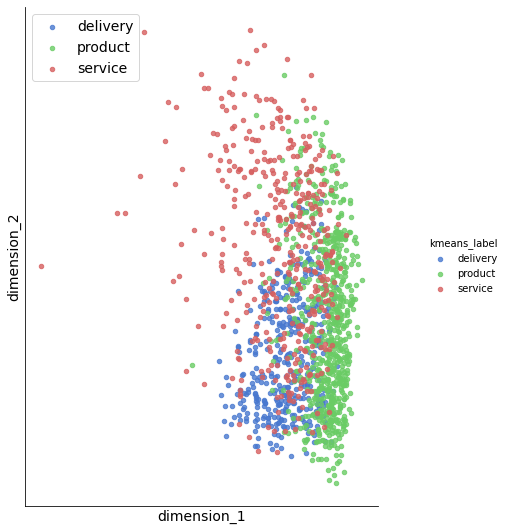

In [23]:
import seaborn as sns
g = sns.lmplot(data=df_plot, x='dimension_1', y='dimension_2', hue='kmeans_label', palette =newPal,
       fit_reg = False, scatter_kws={"s": 20}, size=4)
g.fig.set_size_inches(8,8)
plt.xlabel("dimension_1", fontsize=14)
plt.ylabel("dimension_2", fontsize=14)
plt.legend(fontsize=14)
plt.xticks([])
plt.yticks([])
plt.show()

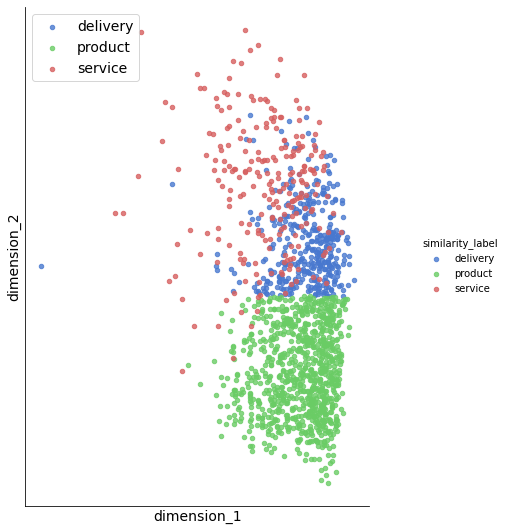

In [24]:
g = sns.lmplot(data=df_plot, x='dimension_1', y='dimension_2', hue='similarity_label', palette =newPal,
       fit_reg = False, scatter_kws={"s": 20}, size = 4)
g.fig.set_size_inches(8,8)
plt.xlabel("dimension_1", fontsize=14)
plt.ylabel("dimension_2", fontsize=14)
plt.legend(fontsize=14)
plt.xticks([])
plt.yticks([])
plt.show()

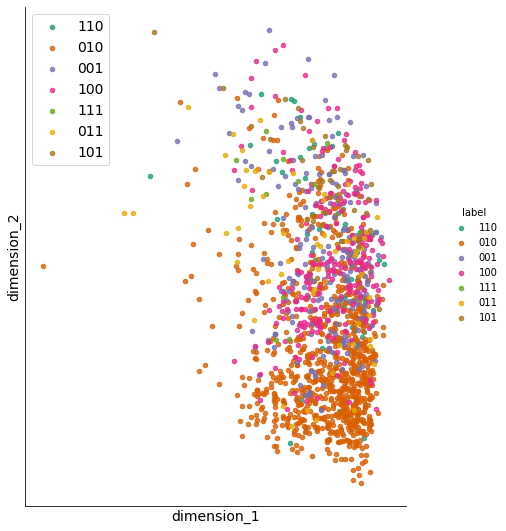

In [25]:
g = sns.lmplot(data=df_plot, x='dimension_1', y='dimension_2', hue='label', palette ='Dark2',
       fit_reg = False, scatter_kws={"s": 20}, size = 4)
g.fig.set_size_inches(8,8)
plt.xlabel("dimension_1", fontsize=14)
plt.ylabel("dimension_2", fontsize=14)
plt.legend(fontsize=14)
plt.xticks([])
plt.yticks([])
plt.show()

In [26]:
df_plot_filtered = df_plot[(df_plot['label'] == '100') | (df_plot['label'] == '010') | (df_plot['label'] == '001')]
df_plot_filtered.head()

,review_id,delivery,product,service,label,kmeans_label_0,kmeans_label_1,kmeans_label_2,sim_del,sim_pro,sim_ser,pred_cluster_0,pred_cluster_1,pred_cluster_2,kmeans_label,similarity_label,dimension_1,dimension_2
1,8198,0,1,0,010,0,1,0,0.923511,0.936423,0.911577,0,1,0,product,product,1.859934,-0.012911
2,5314,0,1,0,010,0,1,0,0.944166,0.958229,0.920406,0,1,0,product,product,1.902395,-0.014063
3,17589,0,1,0,010,0,1,0,0.914172,0.899675,0.905983,1,0,0,product,delivery,1.813847,0.014497
4,31446,0,1,0,010,0,1,0,0.936103,0.944894,0.907786,0,1,0,product,product,1.880997,-0.008791
5,38481,0,0,1,001,0,1,0,0.948304,0.940935,0.933122,1,0,0,product,delivery,1.889239,0.007370


In [27]:
df_plot_filtered['true_label'] = 'delivery'
df_plot_filtered.loc[df_plot_filtered['label']=='010', 'true_label'] = 'product'
df_plot_filtered.loc[df_plot_filtered['label']=='001', 'true_label'] = 'service'
df_plot_filtered.head()

,review_id,delivery,product,service,label,kmeans_label_0,kmeans_label_1,kmeans_label_2,sim_del,sim_pro,sim_ser,pred_cluster_0,pred_cluster_1,pred_cluster_2,kmeans_label,similarity_label,dimension_1,dimension_2,true_label
1,8198,0,1,0,010,0,1,0,0.923511,0.936423,0.911577,0,1,0,product,product,1.859934,-0.012911,product
2,5314,0,1,0,010,0,1,0,0.944166,0.958229,0.920406,0,1,0,product,product,1.902395,-0.014063,product
3,17589,0,1,0,010,0,1,0,0.914172,0.899675,0.905983,1,0,0,product,delivery,1.813847,0.014497,product
4,31446,0,1,0,010,0,1,0,0.936103,0.944894,0.907786,0,1,0,product,product,1.880997,-0.008791,product
5,38481,0,0,1,001,0,1,0,0.948304,0.940935,0.933122,1,0,0,product,delivery,1.889239,0.007370,service


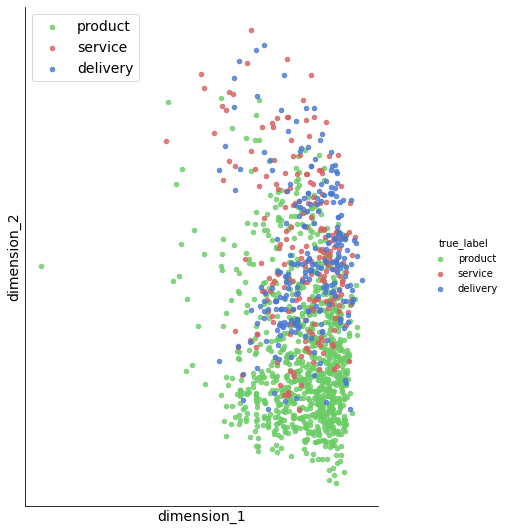

In [28]:
g = sns.lmplot(data=df_plot_filtered,  x='dimension_1', y='dimension_2', hue='true_label', palette =newPal,
       fit_reg = False, scatter_kws={"s": 20}, size = 4)
g.fig.set_size_inches(8,8)
plt.xlabel("dimension_1", fontsize=14)
plt.ylabel("dimension_2", fontsize=14)
plt.legend(fontsize=14)
plt.xticks([])
plt.yticks([])
plt.show()